#### Compare 5 runs per Qwen2.5 Model Size

In [1]:
import pandas as pd
import json

In [20]:

def template_load(model, run, text,P,batch_size=16,analysis_folder='PIIAnalysis'):
    return f'/{model}/forget10/_AllExperiments/{analysis_folder}/{model}_E8_B{batch_size}_C0.1_P_{P}_intext{text}_run{run}/eval_results/eval.csv'

dfs = []

def set_batch_size(model):
    if model == "qwen2.5-14b":
        return 8
    elif model== "qwen2.5-32b":
        return 1
    else:
        return 16

def load_data(base_path, models, runs):
    for model in models:
        for run in runs:
            for text in [False, True]:
                P = 1.2 if text == False else 1
                model_label = 'PerMUtok' if text else 'PerMU'
                batch_size = set_batch_size(model)
                analysis_folder = 'PIIAnalysis' if model=='qwen2.5-32b' else 'PIIAnalysis'

                path = base_path + template_load(model, run, text,P,batch_size=batch_size,analysis_folder=analysis_folder)
                try:
                    df = pd.read_csv(path)
                    df['model'] = model
                    df['run'] = run
                    df['config'] = model_label

                    dfs.append(df)
                except FileNotFoundError:
                    print(f"File not found: {path}")
    return pd.concat(dfs, ignore_index=True)

base_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII'
models = [ "qwen2.5-1.5b", "qwen2.5-7b","qwen2.5-14b","qwen2.5-32b"] #"qwen2.5-3b",
runs = [1,2,3,4,5]

res_df = load_data(base_path, models, runs)
res_df.drop(columns=['Method', 'Submitted By'], inplace=True)
group_df = res_df.groupby(['model','config']).mean(numeric_only=True).reset_index()

File not found: /projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/qwen2.5-14b/forget10/_AllExperiments/PIIAnalysis/qwen2.5-14b_E8_B8_C0.1_P_1_intextTrue_run2/eval_results/eval.csv
File not found: /projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/qwen2.5-32b/forget10/_AllExperiments/PIIAnalysis/qwen2.5-32b_E8_B1_C0.1_P_1.2_intextFalse_run1/eval_results/eval.csv
File not found: /projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/qwen2.5-32b/forget10/_AllExperiments/PIIAnalysis/qwen2.5-32b_E8_B1_C0.1_P_1_intextTrue_run5/eval_results/eval.csv


In [22]:
group_df[['config','model','inverse_scores_forget_exact']]

,config,model,inverse_scores_forget_exact
0,PerMU,qwen2.5-1.5b,0.08100
1,PerMUtok,qwen2.5-1.5b,0.08000
2,PerMU,qwen2.5-14b,0.14400
3,PerMUtok,qwen2.5-14b,0.05500
4,PerMU,qwen2.5-32b,0.05625
5,PerMUtok,qwen2.5-32b,0.03500
6,PerMU,qwen2.5-7b,0.21500
7,PerMUtok,qwen2.5-7b,0.15000


#### Load the Base Model

In [23]:
base_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/save_model/PII'
models = ["qwen2.5-1.5b", "qwen2.5-3b","qwen2.5-7b", "qwen2.5-14b","qwen2.5-32b"]
model_paths = ['full_with_qa_qwen2.5-1.5b_B64_G2_E8_lr2e-5_ComprehensiveQA/eval_results/eval.csv', \
               'full_with_qa_qwen2.5-3b_B64_G2_E7_lr2e-5_ComprehensiveQA/eval_results/eval.csv', \
                'full_with_qa_qwen2.5-7b_B32_G4_E5_lr2e-5_ComprehensiveQA_PadToken/eval_results/eval.csv', \
                'full_with_qa_qwen2.5-14b_B4_G1_E3_lr1e-5/checkpoint-15846/eval_results/eval.csv', \
                    'full_with_qa_qwen2.5-32b_B2_G1_E2_lr1e-5/checkpoint-10564/eval_results/eval.csv']

retain_dfs = []

for i in range(len(models)):
    model = models[i]
    path = base_path + '/' + model_paths[i]
    try:
        df = pd.read_csv(path)
        df['model'] = model
        df['run'] = 0
        df['config'] = 'Base'
        retain_dfs.append(df)
    except FileNotFoundError:
        print(f"File not found: {path}")

base_df = pd.concat(retain_dfs, ignore_index=True)

File not found: /projects/0/hpmlprjs/LLM/danp/UGBench/save_model/PII/full_with_qa_qwen2.5-3b_B64_G2_E7_lr2e-5_ComprehensiveQA/eval_results/eval.csv


In [24]:
def process_columns(df):
    df['exact_forget_score'] = (df['exact_forget_score']*100).round(2)
    df['exact_retain_score'] = (df['exact_retain_score']*100).round(2)
    df['para_scores_forget_exact'] = (df['para_scores_forget_exact']*100).round(2)
    df['para_scores_retain_exact'] = (df['para_scores_retain_exact']*100).round(2)
    df['inverse_scores_forget_exact'] = (df['inverse_scores_forget_exact']*100).round(2)
    df['inverse_scores_retain_exact'] = (df['inverse_scores_retain_exact']*100).round(2)
    df['one_hop_scores_forget_pii'] = (df['one_hop_scores_forget_pii']*100).round(2)
    df['one_hop_scores_retain_pii'] = (df['one_hop_scores_retain_pii']*100).round(2)
    

    return df

def rename_columns(df):
    df.rename(columns={'extraction_scores_forget_exact': 'Naive Forget ESR',
                       'targetted_extraction_scores_forget_exact': 'Targeted Forget ESR',
                       'extraction_scores_retain_exact': 'Naive Test Retain ESR',
                       'targetted_extraction_scores_retain_exact': 'Targeted Test Retain ESR'}, inplace=True)

    df.rename(columns={'exact_forget_score': 'Direct Forget ESR',
                       'inverse_scores_forget_exact': 'Inverse Forget ESR',
                       'exact_retain_score': 'Direct Test Retain ESR',
                       'inverse_scores_retain_exact': 'Inverse Test Retain ESR',
                       'para_scores_retain_exact': 'Paraphrase Test Retain ESR',
                       'para_scores_forget_exact': 'Paraphrase Forget ESR',
                       'one_hop_scores_forget_pii': 'One Hop Forget ESR',
                       'one_hop_scores_retain_pii': 'One Hop Test Retain ESR'}, inplace=True)
    
base_df = process_columns(base_df)
group_df = process_columns(group_df)

rename_columns(base_df)
rename_columns(group_df)

In [25]:
# Extract parameter size and convert to numeric for proper sorting
import pandas as pd

# Create a function to extract parameter size
def extract_param_size(model_name):
    # Extract the number before 'b' (billion parameters)
    import re
    match = re.search(r'(\d+(?:\.\d+)?)b', model_name)
    if match:
        return float(match.group(1))
    return 0
group_df['param_size'] = group_df['model'].apply(extract_param_size)
group_df = group_df.sort_values('param_size').drop('param_size', axis=1)


base_df['param_size'] = base_df['model'].apply(extract_param_size)
base_df = base_df.sort_values('param_size').drop('param_size', axis=1)


In [26]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df, use_harmonic_mean=True):
    """Calculate Model Utility as harmonic mean or arithmetic mean of all specified metrics.
    
    Args:
        df: DataFrame containing the metrics
        use_harmonic_mean: If True, use harmonic mean; if False, use arithmetic mean
    """
    
    utility_columns = [
        'ROUGE Retain', 'Prob. Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', #'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World',#'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    print(f'Skipping columns {[col for col in df.columns if col not in existing_columns]}')
    
    if use_harmonic_mean:
        # Ensure positive values for harmonic mean
        for col in existing_columns:
            df_copy[col] = np.maximum(df_copy[col], 1e-10)
        df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    else:
        # Use arithmetic mean (normal mean)
        df_copy['Model Utility'] = df_copy[existing_columns].mean(axis=1)
    
    return df_copy

base_df = calculate_model_utility(base_df,use_harmonic_mean=False)
group_df = calculate_model_utility(group_df,use_harmonic_mean=False)

Skipping columns ['Paraphrase Forget ESR', 'para_scores_forget_partial_ratio', 'para_scores_forget_token_set_ratio', 'Prob. Forget Paraphrase', 'ROUGE Forget Paraphrase', 'Fluency Forget Paraphrase', 'Paraphrase Test Retain ESR', 'para_scores_retain_partial_ratio', 'para_scores_retain_token_set_ratio', 'Prob. Retain Paraphrase', 'ROUGE Retain Paraphrase', 'Fluency Retain Paraphrase', 'Prob. Forget', 'ROUGE Forget', 'Model Utility', 'Fluency Retain', 'Fluency Real Authors', 'Fluency Real World', 'Fluency Forget', 'Direct Test Retain ESR', 'partial_ratio_retain_score', 'token_set_ratio_retain_score', 'Direct Forget ESR', 'partial_ratio_forget_score', 'token_set_ratio_forget_score', 'One Hop Forget ESR', 'One Hop Test Retain ESR', 'one_hop_scores_forget_name', 'one_hop_scores_retain_name', 'Inverse Forget ESR', 'inverse_scores_forget_partial_ratio', 'inverse_scores_forget_token_set_ratio', 'Inverse Test Retain ESR', 'inverse_scores_retain_partial_ratio', 'inverse_scores_retain_token_set_r

In [27]:
all_df = pd.concat([group_df, base_df], ignore_index=True)

In [28]:
all_df[['ROUGE Retain', 'Prob. Retain','ROUGE Real Authors', 'Prob. Real Authors', 
        'Prob. Real World', 'ROUGE Real World', 'Model Utility','Fluency Forget']] = all_df[['ROUGE Retain', 'Prob. Retain','ROUGE Real Authors', 'Prob. Real Authors', 
        'Prob. Real World', 'ROUGE Real World', 'Model Utility','Fluency Forget']].round(2)

#### Model Utility

In [29]:
all_df[['config','model', 'ROUGE Retain', 'Prob. Retain','ROUGE Real Authors', 'Prob. Real Authors', 
        'Prob. Real World', 'ROUGE Real World', 'Model Utility','Fluency Forget']]

,config,model,ROUGE Retain,Prob. Retain,ROUGE Real Authors,Prob. Real Authors,Prob. Real World,ROUGE Real World,Model Utility,Fluency Forget
0,PerMU,qwen2.5-1.5b,0.58,0.73,0.49,0.59,0.55,0.44,0.56,3.15
1,PerMUtok,qwen2.5-1.5b,0.57,0.61,0.45,0.41,0.40,0.45,0.48,3.78
2,PerMU,qwen2.5-7b,0.82,0.83,0.62,0.55,0.46,0.54,0.64,3.59
3,PerMUtok,qwen2.5-7b,0.81,0.82,0.62,0.43,0.36,0.54,0.60,3.89
4,PerMU,qwen2.5-14b,0.74,0.82,0.20,0.32,0.26,0.32,0.44,3.38
5,PerMUtok,qwen2.5-14b,0.75,0.84,0.20,0.33,0.29,0.29,0.45,3.43
6,PerMU,qwen2.5-32b,0.79,0.86,0.50,0.35,0.23,0.44,0.53,3.08
7,PerMUtok,qwen2.5-32b,0.80,0.89,0.50,0.54,0.34,0.45,0.59,2.25
8,Base,qwen2.5-1.5b,0.72,0.89,0.49,0.36,0.43,0.48,0.56,3.90
9,Base,qwen2.5-7b,0.85,0.96,0.65,0.38,0.32,0.54,0.62,3.95


#### Base Model Evaluation

In [30]:

all_df[all_df['config']=='Base'][['config','model','Direct Forget ESR', 'Paraphrase Forget ESR', 'One Hop Forget ESR', 'Inverse Forget ESR','Direct Test Retain ESR', 'Paraphrase Test Retain ESR', 'One Hop Test Retain ESR', 'Inverse Test Retain ESR','Model Utility','Fluency Forget']]

,config,model,Direct Forget ESR,Paraphrase Forget ESR,One Hop Forget ESR,Inverse Forget ESR,Direct Test Retain ESR,Paraphrase Test Retain ESR,One Hop Test Retain ESR,Inverse Test Retain ESR,Model Utility,Fluency Forget
8,Base,qwen2.5-1.5b,94.92,95.92,15.09,12.0,96.27,95.47,30.43,14.0,0.56,3.90
9,Base,qwen2.5-7b,99.25,99.58,41.51,24.5,99.87,99.67,57.97,24.8,0.62,3.95
10,Base,qwen2.5-14b,99.75,99.50,90.57,71.0,100.00,100.00,91.30,62.0,0.53,3.96
11,Base,qwen2.5-32b,99.50,99.75,52.83,39.5,99.80,99.33,65.22,33.6,0.58,3.96


For base models

- significantly better retention, especially of implict knowledge, even if we try to scale with # of epochs
- lower utility with increasing size, again poinitnign to more overfitting on PII data since model is bigger

In [31]:
all_df[all_df['config']=='PerMUtok'][['config','model','Direct Forget ESR', 'Paraphrase Forget ESR', 'One Hop Forget ESR', 'Inverse Forget ESR','Direct Test Retain ESR', 'Paraphrase Test Retain ESR', 'One Hop Test Retain ESR', 'Inverse Test Retain ESR','Model Utility','Fluency Forget']]

,config,model,Direct Forget ESR,Paraphrase Forget ESR,One Hop Forget ESR,Inverse Forget ESR,Direct Test Retain ESR,Paraphrase Test Retain ESR,One Hop Test Retain ESR,Inverse Test Retain ESR,Model Utility,Fluency Forget
1,PerMUtok,qwen2.5-1.5b,0.75,2.75,5.66,8.0,28.87,26.73,11.59,5.6,0.48,3.78
3,PerMUtok,qwen2.5-7b,2.50,5.00,5.66,15.0,85.80,85.93,27.54,18.8,0.60,3.89
5,PerMUtok,qwen2.5-14b,1.00,0.50,3.77,5.5,78.00,75.80,68.12,50.0,0.45,3.43
7,PerMUtok,qwen2.5-32b,0.00,0.00,1.89,3.5,95.00,94.40,53.62,27.6,0.59,2.25


In [32]:

all_df[all_df['config']=='PerMU'][['config','model','Direct Forget ESR', 'Paraphrase Forget ESR', 'One Hop Forget ESR', 'Inverse Forget ESR','Direct Test Retain ESR', 'Paraphrase Test Retain ESR', 'One Hop Test Retain ESR', 'Inverse Test Retain ESR','Model Utility','Fluency Forget']]

,config,model,Direct Forget ESR,Paraphrase Forget ESR,One Hop Forget ESR,Inverse Forget ESR,Direct Test Retain ESR,Paraphrase Test Retain ESR,One Hop Test Retain ESR,Inverse Test Retain ESR,Model Utility,Fluency Forget
0,PerMU,qwen2.5-1.5b,2.83,2.95,2.26,8.10,38.03,36.03,10.43,9.92,0.56,3.15
2,PerMU,qwen2.5-7b,1.25,3.15,8.30,21.50,91.89,90.05,27.54,19.92,0.64,3.59
4,PerMU,qwen2.5-14b,0.23,0.23,3.77,14.40,72.15,75.41,56.23,52.24,0.44,3.38
6,PerMU,qwen2.5-32b,0.52,0.67,3.30,5.62,88.58,89.08,52.17,21.70,0.53,3.08


In [33]:
all_df['Inner-Scope'] = (all_df['Direct Forget ESR'] + all_df['Paraphrase Forget ESR']) / 2
all_df['Outer-Scope'] = (all_df['One Hop Forget ESR'] + all_df['Inverse Forget ESR']) / 2

all_df['Inner-Scope Retain'] = (all_df['Direct Test Retain ESR'] + all_df['Paraphrase Test Retain ESR']) / 2
all_df['Outer-Scope Retain'] = (all_df['One Hop Test Retain ESR'] + all_df['Inverse Test Retain ESR']) / 2

In [34]:
all_df[all_df['config']=='PerMUtok'][['config','model','Inner-Scope','Outer-Scope']]

,config,model,Inner-Scope,Outer-Scope
1,PerMUtok,qwen2.5-1.5b,1.75,6.830
3,PerMUtok,qwen2.5-7b,3.75,10.330
5,PerMUtok,qwen2.5-14b,0.75,4.635
7,PerMUtok,qwen2.5-32b,0.00,2.695


In [35]:
all_df[all_df['config']=='PerMUtok'][['config','model','Inner-Scope Retain','Outer-Scope Retain']]

,config,model,Inner-Scope Retain,Outer-Scope Retain
1,PerMUtok,qwen2.5-1.5b,27.800,8.595
3,PerMUtok,qwen2.5-7b,85.865,23.170
5,PerMUtok,qwen2.5-14b,76.900,59.060
7,PerMUtok,qwen2.5-32b,94.700,40.610


Trends for now:

- Higher retention of implicit knowledge
- lower retention of explicit knowledge
- higher retention of non-target PII knowledge, likely since memorized information better even with fewer epochs (reflected in the lower utility -> degradation of general knowledge retention from overfitting on data)
- as mentioend, lower model utility with increasing model size


In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d


# Modified version to compare Inner Scope Retain vs Inner Scope Forget with smooth lines
def plot_innerscope_retain_forget_line(df, config='PerMUtok', title='Qwen2.5 ESR Comparison', inner_scope_retain_col='Inner-Scope', inner_scope_forget_col='Outer-Scope'):
    """
    Line plot comparing Inner Scope Retain vs Inner Scope Forget with smooth lines
    """
    # Filter data for specific config
    filtered_df = df[df['config'] == config].copy()
    
    if filtered_df.empty:
        print(f"No data found for config = {config}")
        return None
    
    # Create figure with single subplot for dual y-axis
    fig, ax1 = plt.subplots(figsize=(10, 10))
    
    # Set larger font sizes for better visibility
    plt.rcParams.update({'font.size': 16})
    
    # Extract model sizes and sort by parameter count
    def extract_model_size(model_name):
        if '1.5' in model_name:
            return 1.5
        elif '14' in model_name:
            return 14
        elif '32' in model_name:
            return 32
        elif '7' in model_name:
            return 7
        else:
            return 0
    
    filtered_df['model_size'] = filtered_df['model'].apply(extract_model_size)
    filtered_df = filtered_df.sort_values('model_size')
    
    # Extract data
    models = filtered_df['model'].values
    model_labels = [f"{extract_model_size(model)}B" for model in models]
    inner_scope_retain = filtered_df[inner_scope_retain_col].values  # Already in percentages
    inner_scope_forget = filtered_df[inner_scope_forget_col].values  # Already in percentages

    # Create x-axis positions
    x_pos = np.arange(len(models))
    
    # Define colors
    retain_color = '#1f77b4'  # Blue for retain
    forget_color = '#d62728'  # Red for forget
    
    # Create smooth interpolation
    if len(x_pos) > 2:  # Need at least 3 points for cubic interpolation
        # Create more points for smoother curves
        x_smooth = np.linspace(x_pos[0], x_pos[-1], 100)
        
        # Cubic spline interpolation for smoother curves
        f_retain = interp1d(x_pos, inner_scope_retain, kind='cubic')
        f_forget = interp1d(x_pos, inner_scope_forget, kind='cubic')
        
        inner_scope_retain_smooth = f_retain(x_smooth)
        inner_scope_forget_smooth = f_forget(x_smooth)
        
        # Plot smooth lines
        line1 = ax1.plot(x_smooth, inner_scope_retain_smooth, color=retain_color, 
                         linewidth=3, label='Inner-Scope Retain', alpha=0.8)
        
        # Plot original data points as markers
        ax1.plot(x_pos, inner_scope_retain, color=retain_color, marker='o', 
                 markersize=10, linestyle='none', markeredgecolor='white', 
                 markeredgewidth=2, zorder=5)
        
    else:
        # Fallback for fewer points - use original plotting
        line1 = ax1.plot(x_pos, inner_scope_retain, color=retain_color, marker='o', 
                         label='Inner-Scope Retain', linewidth=3, markersize=10)
    
    # Set primary y-axis properties (inner-scope retain)
    ax1.set_xlabel('Model', fontsize=18, fontweight='bold')
    ax1.set_ylabel('Inner-Scope ESR (%)', fontsize=18, fontweight='bold', color=retain_color)
    ax1.tick_params(axis='y', labelcolor=retain_color, labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(model_labels, rotation=0, ha='center')
    
    # Create secondary y-axis for inner-scope forget metric
    ax2 = ax1.twinx()
    
    # Plot smooth forget line
    if len(x_pos) > 2:
        line2 = ax2.plot(x_smooth, inner_scope_forget_smooth, color=forget_color, 
                         linewidth=3, label='Inner-Scope Forget', alpha=0.8)
        
        # Plot original data points as markers
        ax2.plot(x_pos, inner_scope_forget, color=forget_color, marker='s', 
                 markersize=10, linestyle='none', markeredgecolor='white', 
                 markeredgewidth=2, zorder=5)
    else:
        line2 = ax2.plot(x_pos, inner_scope_forget, color=forget_color, marker='s', 
                         label='Inner-Scope Forget', linewidth=3, markersize=10)
    
    # Set secondary y-axis properties (inner-scope forget)
    ax2.set_ylabel('Inner-Scope ESR (%)', fontsize=18, fontweight='bold', color=forget_color)
    ax2.tick_params(axis='y', labelcolor=forget_color, labelsize=16)
    
    # Add text annotations for clarity
    ax1.text(0.02, 0.39, 'Test Retain ↑', transform=ax1.transAxes, fontsize=16, 
             color=retain_color, fontweight='bold', ha='left', va='top')
    ax1.text(0.98, 0.39, 'Forget ↓', transform=ax1.transAxes, fontsize=16, 
             color=forget_color, fontweight='bold', ha='right', va='top')
    
    ax1.text(0.02, 0.33, f'Scale: 30 - 90%', 
             transform=ax1.transAxes,
             bbox=dict(boxstyle="round,pad=0.4", facecolor='lightblue', alpha=1),
             fontsize=14, fontweight='bold', verticalalignment='top', ha='left')
    
    # Scale box for Forget (under Forget label)
    ax2.text(0.98, 0.33, f'Scale: 0% - 3.5%', 
             transform=ax2.transAxes,
             bbox=dict(boxstyle="round,pad=0.4", facecolor='lightcoral', alpha=1),
             fontsize=14, fontweight='bold', verticalalignment='top', 
             horizontalalignment='right')
    
    # Color the y-axis spines to match the metrics
    ax1.spines['left'].set_color(retain_color)
    ax1.spines['left'].set_linewidth(2)
    ax2.spines['right'].set_color(forget_color)
    ax2.spines['right'].set_linewidth(2)
    
    # Style the plot
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f'{title}',
                  fontsize=20, fontweight='bold', pad=20)
    
    # Create combined legend
    # lines1, labels1 = ax1.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=16)
    
    plt.tight_layout()
    return fig

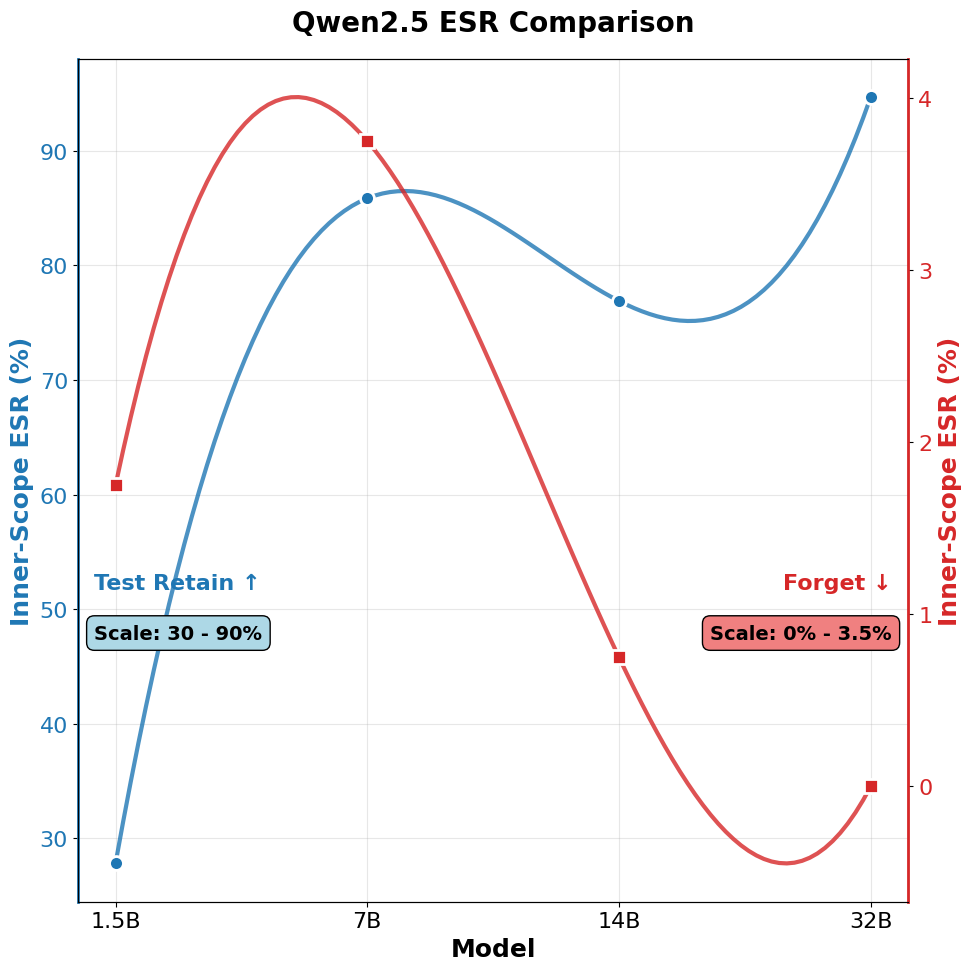

In [57]:
# Filter your data as mentioned
filtered_data = all_df[all_df['config']=='PerMUtok'][['config','model','Inner-Scope','Inner-Scope Retain']]

# Create the plot
fig = plot_innerscope_retain_forget_line(filtered_data, config='PerMUtok', inner_scope_retain_col='Inner-Scope Retain', inner_scope_forget_col='Inner-Scope')
plt.show()